In [1]:
from io import StringIO
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns

In [2]:
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, random_split

torch.set_default_dtype(torch.float64)
# torch.manual_seed(42)
device = "cpu"

In [3]:
from erisk import metrics

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# !pip install --upgrade pandas transformers -q

In [6]:
# !unzip datasets.zip

### model

In [7]:
class MyReg(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1),
            nn.ReLU(),
            # nn.LogSoftmax(),
        )

    def forward(self, x):
        return self.layers(x)


In [8]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=.001, max_beta=.1):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.max_beta = max_beta

        self.counter = 0
        self.early_stop = False

    def __call__(self, val_losses, train_loss=None):

        if len(val_losses) < 2:
            return

        curr, prev = val_losses[-1], val_losses[-2]
        is_delta = (
            (prev - curr) < self.min_delta
        )
        is_beta = (
            (curr - train_loss) > self.max_beta
        )

        if is_beta or is_delta:
            self.counter += 1

        if self.counter >= self.tolerance:
            self.early_stop = True


In [9]:
class MyTrainer:
    def __init__(self, dataset, input_size, batch_size=32) -> None:
        self.train_losses = list()
        self.val_losses = list()
        self.batch_size = batch_size
        self.load_data(dataset)

        self.model = MyReg(input_size=input_size)
        # self.lossf = nn.CrossEntropyLoss()
        self.lossf = nn.L1Loss()
        self.optif = AdamW(
            self.model.parameters(),
            lr=1e-3,
        )
        # self.optif = torch.optim.SGD(
        #     self.model.parameters(),
        #     lr=1e-3,
        #     momentum=0.9,
        # )

    def load_data(self, dataset):
        train_dt, val_dt, test_dt = random_split(dataset, [0.6, 0.2, 0.2])
        self._train_dl = DataLoader(
            train_dt,
            batch_size=self.batch_size,
            shuffle=True,
        )

        self._val_dl = DataLoader(val_dt, shuffle=True)
        self._test_dl = DataLoader(test_dt, shuffle=True)

    def _train_one(self):
        epoch_loss = 0.0
        for _, data in enumerate(self._train_dl):
            inputs, targets = data
            outputs = self.model(inputs)

            self.optif.zero_grad()
            batch_loss = self.lossf(outputs[:, 0], targets)
            batch_loss.backward()
            self.optif.step()

            epoch_loss += batch_loss.item()
        return epoch_loss / len(self._train_dl)

    def _val_one(self):
        epoch_loss = 0.0
        for _, data in enumerate(self._val_dl):
            inputs, target = data
            outputs = self.model(inputs)

            loss = self.lossf(outputs[:, 0], target)
            epoch_loss += loss.item()
        return epoch_loss / len(self._val_dl)

    def fit(self, epochs=1, early_stopping=None):
        for epoch in range(epochs):
            t_loss = self._train_one()
            self.train_losses.append(t_loss)

            self.model.eval()

            v_loss = self._val_one()
            self.val_losses.append(v_loss)
            print(f"validation loss {v_loss:.3f} at epoch {epoch}")

            # early stopping
            if early_stopping is not None:
                early_stopping(self.val_losses, t_loss)
                if early_stopping.early_stop:
                    print(f"early stopping...")
                    break

    def gasp(self):
        return [(self.model(inputs).item(), target.item()) for inputs, target in self._test_dl]

### data

Loading and mergin dataset

In [10]:
data_text = ""

for filename in sorted(["ds", "ts_hs", "ts_ht"]):
    with open(
        Path("datasets", "task_0", f"{filename}.tsv"), "rt", encoding="utf8"
    ) as f:
        data_text += f.read()

df = pd.read_csv(StringIO(data_text), sep="\t")
df = df.drop_duplicates().reset_index(names="old_idx").reset_index(names="new_idx")


In [11]:
df.label = df.label.astype(int)

### lex

In [12]:
import liwc
to_liwc, categories = liwc.load_token_parser('dic/LIWC2007_English080730.dic')
K = len(categories)

kat_lookup = dict(zip(categories, range(K)))

In [13]:
class LexDataset(Dataset):
    def __init__(self, df, x_col="pp_text", y_col="label"):
        self.df = df
        self.x_col = x_col
        self.y_col = y_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        counter = {k: 0 for k in categories}
        for word in self.df.loc[idx, self.x_col].split():
            for k in list(to_liwc(word)):
                counter[k] += 1
        X = (
            np.array([counter[k] for k in categories]) / sum(counter.values())
            if sum(counter.values())
            else np.zeros(K)
        )
        # y = np.zeros(2)
        # y[self.df.loc[idx, self.y_col]] = 1
        y = self.df.loc[idx, self.y_col]

        return X, y

    def __iter__(self):
        self.a = 0
        return self

    def __next__(self):
        if self.a < len(self):
            value = self[self.a]
            self.a += 1
            return value
        else:
            raise StopIteration


In [14]:
ds_lex = LexDataset(df)

In [15]:
X_lex, y_lex = zip(*ds_lex)

In [16]:
trainer = MyTrainer(ds_lex, 64)
trainer.fit(
    epochs=100,
    early_stopping=EarlyStopping(
        tolerance=4,
        min_delta=0.0,
        max_beta=0.1,
    ),
)


validation loss 0.480 at epoch 0
validation loss 0.474 at epoch 1
validation loss 0.468 at epoch 2
validation loss 0.462 at epoch 3
validation loss 0.456 at epoch 4
validation loss 0.449 at epoch 5
validation loss 0.443 at epoch 6
validation loss 0.437 at epoch 7
validation loss 0.431 at epoch 8
validation loss 0.425 at epoch 9
validation loss 0.420 at epoch 10
validation loss 0.415 at epoch 11
validation loss 0.410 at epoch 12
validation loss 0.406 at epoch 13
validation loss 0.402 at epoch 14
validation loss 0.399 at epoch 15
validation loss 0.396 at epoch 16
validation loss 0.394 at epoch 17
validation loss 0.392 at epoch 18
validation loss 0.390 at epoch 19
validation loss 0.388 at epoch 20
validation loss 0.387 at epoch 21
validation loss 0.386 at epoch 22
validation loss 0.385 at epoch 23
validation loss 0.384 at epoch 24
validation loss 0.383 at epoch 25
validation loss 0.382 at epoch 26
validation loss 0.381 at epoch 27
validation loss 0.381 at epoch 28
validation loss 0.380 at

<AxesSubplot: >

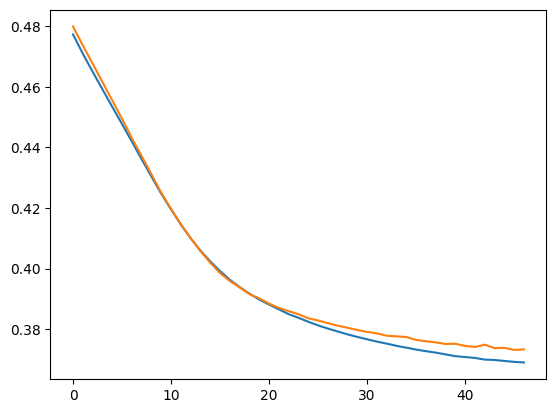

In [17]:
sns.lineplot(trainer.train_losses)
sns.lineplot(trainer.val_losses)

In [18]:
xi_weights = trainer.model.layers[0].weight[0].detach().numpy()

In [19]:
y_hat, y_true = list(zip(*trainer.gasp()))
y_hat = [1 if e>0.5 else 0 for e in y_hat]

In [20]:
metrics(y_hat, y_true)

F1: 0.70
Precision: 0.69
Recall: 0.71
Accuracy: 0.71


### born lex

In [21]:
from sklearn.model_selection import train_test_split
from bornrule import BornClassifier
from collections import defaultdict

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_lex,
    y_lex,
    test_size=0.2,
    random_state=42,
    stratify=y_lex,
)

In [23]:
amplitude = 0.5 #amplitude
balance = 1 #balance
entropy = 1 #entropy

In [24]:
born = BornClassifier(a=amplitude, b=balance, h=entropy)
born.fit(X=X_train, y=y_train)

BornClassifier(b=1, h=1)

In [25]:
y_hat = born.predict(X_test)
metrics(y_hat, y_test)

F1: 0.63
Precision: 0.65
Recall: 0.62
Accuracy: 0.65


In [26]:
born.classes_

array([0, 1])

In [27]:
weights = born.explain()[:,1]
scores = sorted(list(zip(categories, weights)), key = lambda x : x[-1], reverse=True)
kwscores = defaultdict(float, scores)

In [28]:
scores[:15]

[('i', 0.012541492481592243),
 ('work', 0.011617812255721238),
 ('assent', 0.007522012568021944),
 ('sad', 0.007463258446255146),
 ('health', 0.006889467324162289),
 ('leisure', 0.0057710508860062786),
 ('ppron', 0.00560310530425819),
 ('money', 0.005426777055746855),
 ('posemo', 0.005207359259779314),
 ('negemo', 0.005121484877754135),
 ('feel', 0.004527219872281263),
 ('space', 0.003819259460512905),
 ('anx', 0.0036360851519248033),
 ('inhib', 0.0032653448548397124),
 ('achieve', 0.0031674857972681988)]

### RoBERTa

In [29]:
y = torch.tensor(df.label).to(device)

In [30]:
BATCH_SIZE = 64

In [31]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)

In [32]:
tokenizer_hf = AutoTokenizer.from_pretrained("ShreyaR/finetuned-roberta-depression")
model = AutoModelForSequenceClassification.from_pretrained("ranieri-unimi/test-trainer").to(device)

In [33]:
TH = tokenizer_hf.batch_encode_plus(
    df.pp_text.to_list(),
    return_tensors="pt",
    padding=True,
    truncation=True,
).to(device)


In [34]:
# X = None
# with torch.no_grad():
#     for i in tqdm(range(0, len(y), BATCH_SIZE)):
#         input_ids = TH.input_ids[i : i + BATCH_SIZE, :]
#         result = model(input_ids, output_hidden_states=True)
#         cls_batch = result.hidden_states[-1][:, 0, :]
#         try:
#             X = torch.cat((X, cls_batch))
#         except:
#             X = cls_batch
# torch.save(X, "stash/X.cls.pt")

In [35]:
X = torch.load("stash/X.cls.pt").to(device)
X = [e for e in X]

In [36]:
class RobDataset(Dataset):
    def __init__(self, X_list, y_list):
        self.X_list = X_list
        self.y_list = y_list

    def __len__(self):
        return len(self.y_list)

    def __getitem__(self, idx):
        return self.X_list[idx], self.y_list[idx]

In [37]:
ds_rob = RobDataset(X, y)

In [38]:
trainer = MyTrainer(ds_rob, 768)
trainer.fit(
    epochs=100,
    early_stopping=EarlyStopping(
        tolerance=8,
        min_delta=0.0,
        max_beta=0.12,
    ),
)

validation loss 0.461 at epoch 0
validation loss 0.398 at epoch 1
validation loss 0.381 at epoch 2
validation loss 0.392 at epoch 3
validation loss 0.388 at epoch 4
validation loss 0.384 at epoch 5
validation loss 0.380 at epoch 6
validation loss 0.379 at epoch 7
validation loss 0.390 at epoch 8
validation loss 0.396 at epoch 9
validation loss 0.401 at epoch 10
validation loss 0.389 at epoch 11
validation loss 0.376 at epoch 12
validation loss 0.377 at epoch 13
validation loss 0.390 at epoch 14
validation loss 0.375 at epoch 15
validation loss 0.374 at epoch 16
validation loss 0.400 at epoch 17
validation loss 0.375 at epoch 18
validation loss 0.375 at epoch 19
validation loss 0.389 at epoch 20
early stopping...


<AxesSubplot: >

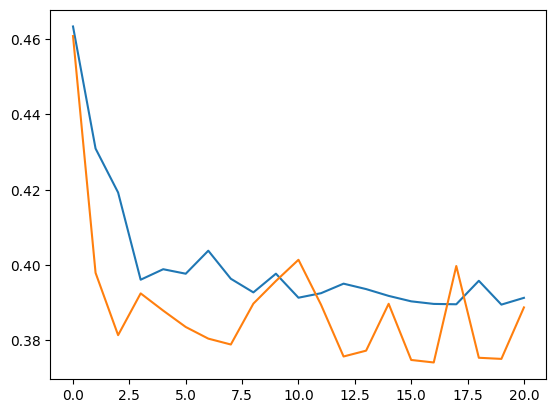

In [39]:
sns.lineplot(trainer.train_losses)
sns.lineplot(trainer.val_losses)

In [40]:
wo_weights = trainer.model.layers[0].weight[0].detach().numpy()

In [41]:
y_hat, y_true = list(zip(*trainer.gasp()))
y_hat = [1 if e>0.5 else 0 for e in y_hat]

In [42]:
metrics(y_hat, y_true)

F1: 0.29
Precision: 0.91
Recall: 0.17
Accuracy: 0.59


### reg match

In [43]:
from sklearn.linear_model import ElasticNet, Ridge, LinearRegression

In [44]:
y_lex = np.array([ds_lex[i][0] for i in range(len(ds_lex))])
x_sem = np.array([ds_rob[i][0].numpy() for i in range(len(ds_rob))])

In [45]:
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(x_sem, y_lex)

print(ridge_reg.coef_)
# print(ridge_reg.intercept_)

[[-3.73287740e-03  1.35999002e-01 -2.91835908e-03 ...  3.28571175e-01
  -1.75643968e-02 -1.77180860e-01]
 [ 1.40839331e-02  1.98991041e-02 -5.33868533e-03 ...  7.77323627e-02
   1.48232016e-02 -3.59815514e-02]
 [ 1.12688929e-02  1.12363939e-02 -6.46624173e-03 ...  6.32734323e-02
   1.04695655e-02 -2.47157306e-02]
 ...
 [ 5.53938214e-03 -2.58408594e-02  4.48185549e-03 ... -6.87063416e-02
   5.38023242e-03  3.57190829e-02]
 [-5.54531361e-04 -1.43057164e-04  6.00416107e-04 ... -2.27772934e-03
  -2.65877164e-04  8.90534845e-04]
 [ 1.07157045e-04  1.97275698e-04 -1.04539935e-04 ...  4.27690927e-05
   3.14536807e-05  1.10099397e-04]]


In [46]:
P = ridge_reg.coef_

In [47]:
def rescale(v, method):
    a = np.array(v)
    match method.lower():
        case "prob":
            a = (a - a.min()) / (a.max() - a.min())
        case "softmax":
            a = np.exp(a) / sum(np.exp(a))
        case "std":
            a = (a - a.mean()) / (a.std())
        case "relu":
            a = np.maximum(0, a)
        case _:
            print(f'"{rescale}" is ignored because is not a supported rescale method')
    return a

def md_rescale(A, method):
    return np.array([rescale(a, method) for a in A])

In [48]:
def plot_coeff(M, category):
    i = categories.index(category)
    ax = sns.heatmap(
        (M[i]//1e-11).reshape((32, 24)),
        # cmap=sns.color_palette("vlag", as_cmap=True),
    )
    ax.set(
        xticklabels=[],
        yticklabels=[],
        title=category.upper(),
    )
    ax.tick_params(bottom=False, left=False)

In [49]:
# plot_coeff(md_rescale(P.T, "relu").T, "posemo")

In [50]:
error_term = np.dot(P, wo_weights) - xi_weights

In [51]:
np.dot(P, wo_weights).shape

(64,)

<AxesSubplot: ylabel='Count'>

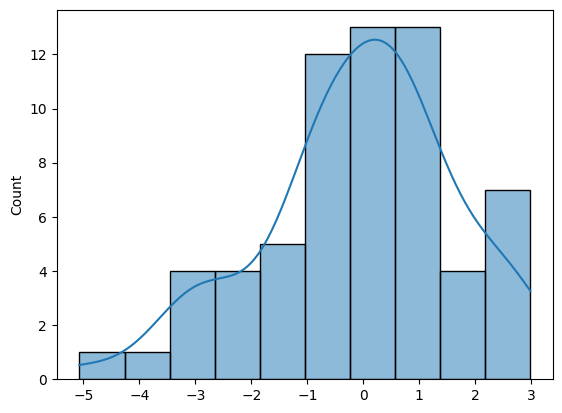

In [52]:
sns.histplot(error_term, kde=True)

In [53]:
lx_error_term = np.dot(P.T, xi_weights) - wo_weights

<AxesSubplot: ylabel='Count'>

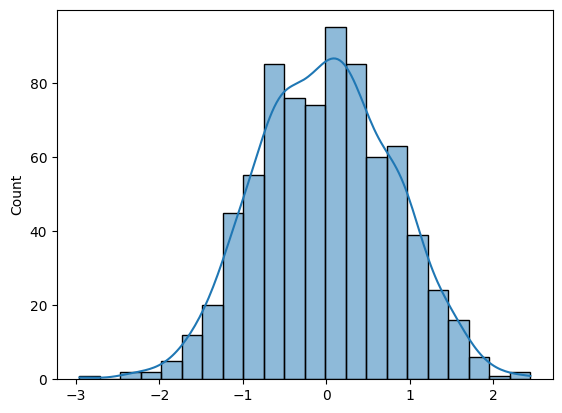

In [54]:
sns.histplot(lx_error_term, kde=True)

In [55]:
stats.shapiro(error_term), stats.shapiro(lx_error_term)

(ShapiroResult(statistic=0.967255711555481, pvalue=0.08699003607034683),
 ShapiroResult(statistic=0.9980584383010864, pvalue=0.5366822481155396))

In [56]:
stats.ttest_ind(np.dot(P, wo_weights), xi_weights)

Ttest_indResult(statistic=-0.26086632031838675, pvalue=0.7946214758829483)

In [57]:
stats.ttest_ind(np.dot(P.T, xi_weights), wo_weights)

Ttest_indResult(statistic=-0.3558720675914104, pvalue=0.7219853073600127)